# Imports

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt

import spacy
import re
import string
import nltk
from nltk.corpus import stopwords
import wordcloud

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from tensorflow.keras import layers
from keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D

from keras.initializers import Constant
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV

import warnings

In [4]:
from IPython.display import HTML
def pretty_print_df(value_counts_):
    "Quick function to display value counts more nicely"
    display(HTML(pd.DataFrame(value_counts_).to_html()))

In [5]:
plt.style.use(style="seaborn")
%matplotlib inline

# Data Importing

In [6]:
reviews = pd.read_csv('amazon_reviews/processed_reviews_split_surnamesK_minimal.csv')

In [7]:
reviews.describe()

,review_score
count,32918.000000
mean,4.089222
std,1.433766
min,-1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [8]:
reviews.head()

,review_id,text,verified,review_score,product_category
0,product_review_000000,"Though this game is still very good, it's can'...",False,3.0,video_games
1,product_review_000001,best game everust like being on the field. th...,True,5.0,video_games
2,product_review_000002,"Battlefield One is a great game, it offers a l...",True,-1.0,video_games
3,product_review_000003,No doubt there will be improvements in portabl...,False,5.0,NaN
4,product_review_000004,This is my first Animal Crossing game so go ea...,False,4.0,video_games


# Preprocessing

Review ID cleaning

In [9]:
reviews['review_id'] = reviews['review_id'].str[15:] #Run only once
reviews = reviews.astype({'review_id': int})

Checking for duplicates

In [10]:
dup = reviews.duplicated()
c = 0
for i in range (0,len(dup)):
    if dup[i] == True:
        c=c+1
print('Number of duplicates:',c)

Number of duplicates: 0


Checking for & Removing Nulls

In [11]:
reviews.isnull().values.any() #Check if there is nulls

True

In [12]:
reviews.isnull().sum() # Check where the nulls occur

review_id             0
text                 11
verified            120
review_score          0
product_category    906
dtype: int64

In [13]:
reviews = reviews.dropna(subset=["text"])
reviews = reviews.dropna(subset=['product_category'])

In [14]:
reviews.isnull().sum() # Double Checking

review_id             0
text                  0
verified            113
review_score          0
product_category      0
dtype: int64

Removing the -1 review_score rows

In [15]:
reviews.drop(reviews[reviews.review_score == -1].index, inplace=True)
reviews.reset_index(drop=True, inplace=True)

In [16]:
reviews.describe()

,review_id,review_score
count,31095.000000,31095.000000
mean,16468.950571,4.232771
std,9500.909519,1.166650
min,0.000000,1.000000
25%,8250.500000,4.000000
50%,16463.000000,5.000000
75%,24691.500000,5.000000
max,32917.000000,5.000000


Text & Category columns -> String

In [17]:
reviews = reviews.astype({'text': str})
reviews = reviews.astype({'product_category': str})

Defining Text Cleaning Functions

In [18]:
# URL & HTML Removal
def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)

def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

In [19]:
# Punctuation Removal
def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

In [20]:
#Stopwords Removal
stop = set(stopwords.words("english"))
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]

    return " ".join(text)

Applying functions to data

In [21]:
reviews["text"] = reviews.text.map(lambda x: remove_URL(x))
reviews["text"] = reviews.text.map(lambda x: remove_html(x))
reviews["text"] = reviews.text.map(lambda x: remove_punct(x))
reviews["text"] = reviews["text"].map(remove_stopwords)
reviews['text'] = reviews['text'].apply(lambda x: nltk.WordNetLemmatizer().lemmatize(x)) # Lemmatizing JIC

In [22]:
reviews.head()

,review_id,text,verified,review_score,product_category
0,0,though game still good cant compete curse monk...,False,3.0,video_games
1,1,best game everust like field pitchin hiting ba...,True,5.0,video_games
2,4,first animal crossing game go easy game cute e...,False,4.0,video_games
3,5,cute mic us working musicians need cute need s...,True,3.0,musical_instruments
4,6,fian fantasy 9 go best one series far graphics...,False,4.0,video_games


# Data Exploration

Adding exploratory columns

In [23]:
def sentiments(df):
    if df['review_score'] > 3.0:
        return 'Positive'
    elif df['review_score'] < 3.0:
        return 'Negative'
    else: return 'Neutral'

In [24]:
reviews["length"] = reviews.text.map(lambda x: len(x))
reviews["word_count"] = reviews.text.str.split().map(lambda x: len(x))
reviews['sentiment'] = reviews.apply(sentiments, axis=1)

In [25]:
reviews.describe()

,review_id,review_score,length,word_count
count,31095.000000,31095.000000,31095.000000,31095.000000
mean,16468.950571,4.232771,401.171796,60.898054
std,9500.909519,1.166650,709.990398,105.036156
min,0.000000,1.000000,0.000000,0.000000
25%,8250.500000,4.000000,69.000000,11.000000
50%,16463.000000,5.000000,162.000000,25.000000
75%,24691.500000,5.000000,415.000000,64.000000
max,32917.000000,5.000000,19197.000000,2796.000000


Category Check

In [26]:
vg = reviews.loc[reviews['product_category'] == 'video_games']
m = reviews.loc[reviews['product_category'] == 'musical_instruments']

In [27]:
stars = reviews['review_score'].value_counts()
pretty_print_df(stars)

,review_score
5.0,18711
4.0,6019
3.0,3060
1.0,1803
2.0,1502


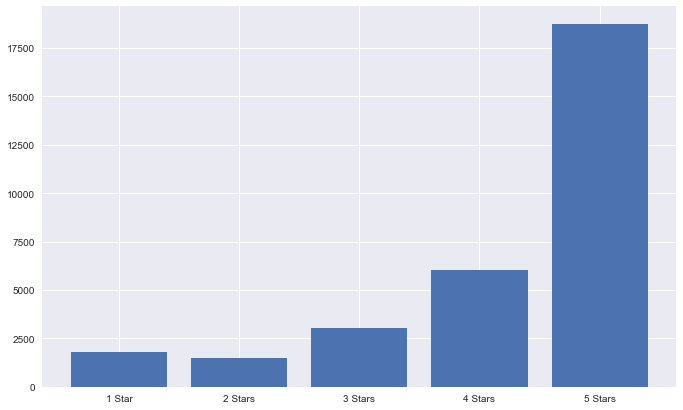

In [28]:
plt.figure(1, figsize=(25, 7))
plt.subplot(1, 2, 1)
_ = plt.bar(["1 Star", "2 Stars", "3 Stars", "4 Stars", "5 Stars"], [stars[1],stars[2],stars[3],stars[4],stars[5]])
plt.savefig('Star Distribution.pdf')
plt.show()

In [29]:
pretty_print_df(reviews['product_category'].value_counts())

,product_category
video_games,21127
musical_instruments,9968


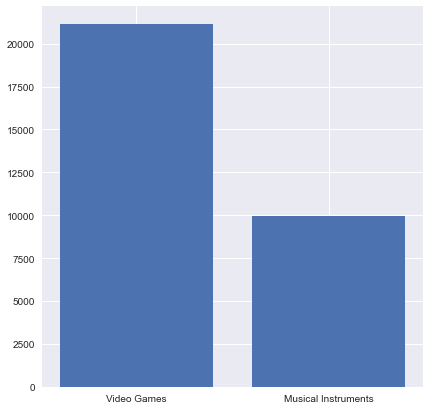

In [30]:
Video_Games = vg.shape[0]
Musical_Instruments = m.shape[0]

plt.figure(1, figsize=(15, 7))
plt.subplot(1, 2, 1)
_ = plt.bar(["Video Games", "Musical Instruments"], [Video_Games, Musical_Instruments])
plt.savefig('Category Distribution.pdf')
plt.show()

In [31]:
m.text.value_counts()[:10]

good            8
work            7
great           7
love            6
ok              5
good product    5
best            5
                4
works great     4
happy           4
Name: text, dtype: int64

In [32]:
vg.text.value_counts()[:10]

good         15
love         12
great        10
good game    10
like          9
              8
expected      7
love game     7
ok            6
excellent     6
Name: text, dtype: int64

Sentiments for each product category

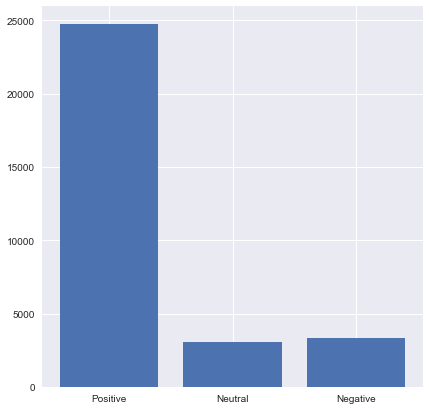

In [33]:
# All
x = reviews.loc[reviews['sentiment'] == 'Positive']
y = reviews.loc[reviews['sentiment'] == 'Negative']
z = reviews.loc[reviews['sentiment'] == 'Neutral']

plt.figure(1, figsize=(15, 7))
plt.subplot(1, 2, 1)
_ = plt.bar(["Positive", "Neutral" ,"Negative"], [x.shape[0],z.shape[0],y.shape[0]])
plt.savefig('Sentiment Distribution.pdf')
plt.show()

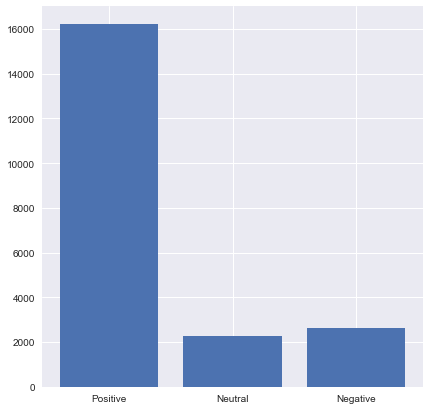

In [34]:
# Video Games
x = vg.loc[vg['sentiment'] == 'Positive']
y = vg.loc[vg['sentiment'] == 'Negative']
z = vg.loc[vg['sentiment'] == 'Neutral']

plt.figure(1, figsize=(15, 7))
plt.subplot(1, 2, 1)
_ = plt.bar(["Positive", "Neutral" ,"Negative"], [x.shape[0],z.shape[0],y.shape[0]])
plt.savefig('Sentiment across vg.pdf')
plt.show()

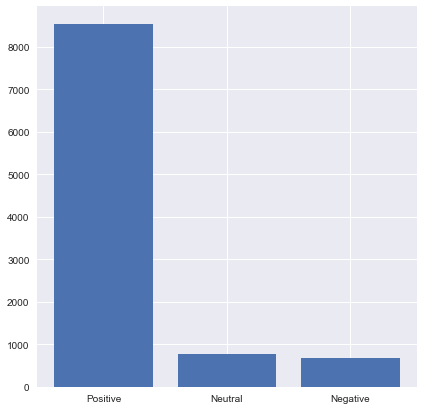

In [35]:
# Musical Instruments
x = m.loc[m['sentiment'] == 'Positive']
y = m.loc[m['sentiment'] == 'Negative']
z = m.loc[m['sentiment'] == 'Neutral']

plt.figure(1, figsize=(15, 7))
plt.subplot(1, 2, 1)
_ = plt.bar(["Positive", "Neutral" ,"Negative"], [x.shape[0],z.shape[0],y.shape[0]])
plt.savefig('Sentiment across music.pdf')
plt.show()

Lengths exploration

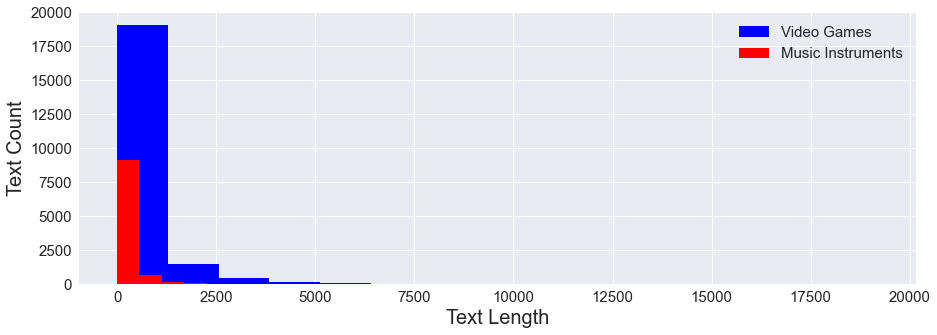

In [36]:
plt.figure(1, figsize=(15, 5))
plt.subplot(1, 1, 1)
plt.hist(vg['length'], color="blue", bins=15)
plt.hist(m['length'], color="red", bins=15)
plt.xlabel('Text Length', fontsize=20)
plt.ylabel('Text Count', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['Video Games','Music Instruments'], fontsize=15)
plt.savefig('Text length histogram.pdf')
plt.show()

Visualising the number of words in each document in a histogram

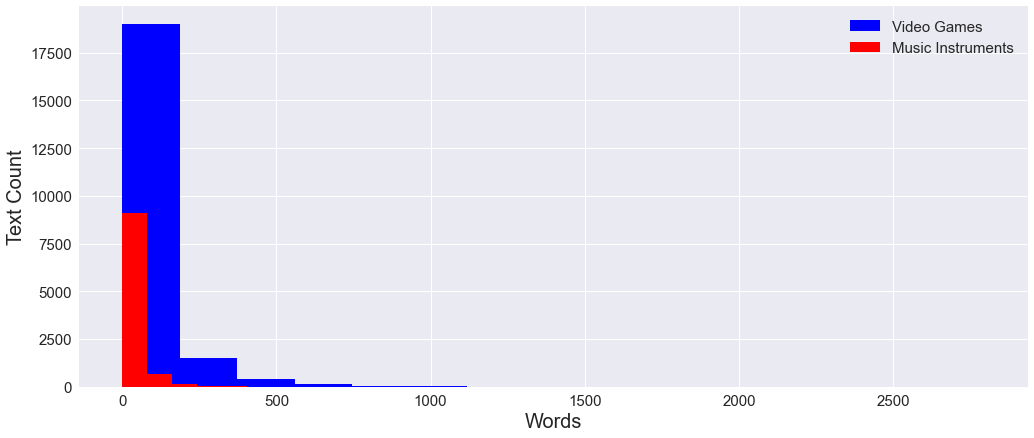

In [37]:
plt.figure(1, figsize=(17, 7))
plt.subplot(1, 1, 1)
plt.hist(vg['word_count'], color="blue", bins=15)
plt.hist(m['word_count'], color="red", bins=15)
plt.xlabel('Words', fontsize=20)
plt.ylabel('Text Count', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['Video Games','Music Instruments'], fontsize=15)
plt.savefig('Word count histogram.pdf')
plt.show()

In [38]:
#Exploring in numbers
print('All:')
pretty_print_df(reviews.describe())
print('Video Games:')
pretty_print_df(vg.describe())
print('Music:')
pretty_print_df(m.describe())

All:


,review_id,review_score,length,word_count
count,31095.000000,31095.000000,31095.000000,31095.000000
mean,16468.950571,4.232771,401.171796,60.898054
std,9500.909519,1.166650,709.990398,105.036156
min,0.000000,1.000000,0.000000,0.000000
25%,8250.500000,4.000000,69.000000,11.000000
50%,16463.000000,5.000000,162.000000,25.000000
75%,24691.500000,5.000000,415.000000,64.000000
max,32917.000000,5.000000,19197.000000,2796.000000


Video Games:


,review_id,review_score,length,word_count
count,21127.000000,21127.000000,21127.000000,21127.000000
mean,16512.998722,4.140342,485.377810,73.545558
std,9491.616945,1.225747,811.080661,119.910117
min,0.000000,1.000000,0.000000,0.000000
25%,8307.000000,4.000000,81.000000,13.000000
50%,16489.000000,5.000000,195.000000,31.000000
75%,24715.500000,5.000000,533.000000,81.000000
max,32916.000000,5.000000,19197.000000,2796.000000


Music:


,review_id,review_score,length,word_count
count,9968.000000,9968.000000,9968.000000,9968.000000
mean,16375.591292,4.428672,222.698636,34.091894
std,9520.377873,1.002519,362.395611,53.704414
min,5.000000,1.000000,0.000000,0.000000
25%,8116.500000,4.000000,52.000000,8.000000
50%,16408.500000,5.000000,121.000000,19.000000
75%,24640.000000,5.000000,250.000000,39.000000
max,32917.000000,5.000000,8461.000000,1216.000000


Wordcloud for the most used words

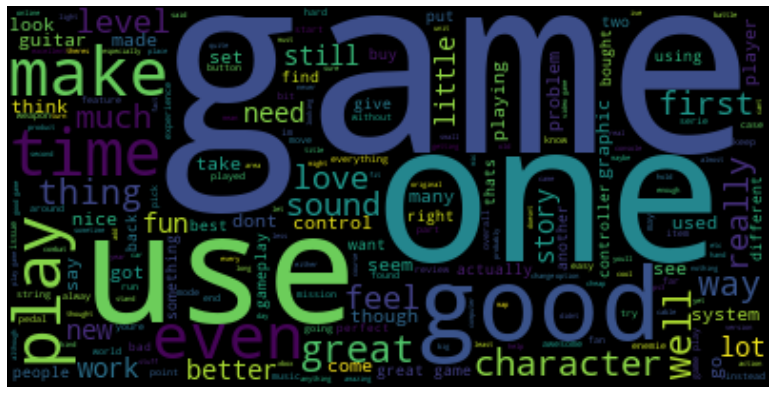

In [39]:
plt.figure(1, figsize=(20, 7))
common_words=''
for i in reviews.text:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('Wordcloud.pdf')
plt.show()

Data head

In [40]:
reviews.head()

,review_id,text,verified,review_score,product_category,length,word_count,sentiment
0,0,though game still good cant compete curse monk...,False,3.0,video_games,301,48,Neutral
1,1,best game everust like field pitchin hiting ba...,True,5.0,video_games,106,16,Positive
2,4,first animal crossing game go easy game cute e...,False,4.0,video_games,1185,185,Positive
3,5,cute mic us working musicians need cute need s...,True,3.0,musical_instruments,328,52,Neutral
4,6,fian fantasy 9 go best one series far graphics...,False,4.0,video_games,273,47,Positive


# NLP & ML

Encoding Product Categories & Sentiment

In [41]:
# 1 for Video Games, 0 for Musical Instruments
le = preprocessing.LabelEncoder()

cat = reviews.product_category
enc_cat = le.fit_transform(cat)

In [42]:
# 2 for Positive (4 & 5 Stars), 1 for Neutral (3 Stars) ,0 for Negative (1 & 2 Stars)
se = preprocessing.LabelEncoder()

s = reviews.sentiment
enc_s = se.fit_transform(s)

### Not used in the end, good for future works.

Creating the new ML dataframe

In [43]:
ML = df({
    'Text': reviews.text,
    'Review_Score': reviews.review_score,
    'product_category': enc_cat,
    'Sentiment': enc_s,
})
ML

,Text,Review_Score,product_category,Sentiment
0,though game still good cant compete curse monk...,3.0,1,1
1,best game everust like field pitchin hiting ba...,5.0,1,2
2,first animal crossing game go easy game cute e...,4.0,1,2
3,cute mic us working musicians need cute need s...,3.0,0,1
4,fian fantasy 9 go best one series far graphics...,4.0,1,2
...,...,...,...,...
31090,make child happy good price,4.0,0,2
31091,sweat,4.0,1,2
31092,brainer tons new stuff days additional game pl...,5.0,1,2
31093,got game like sid meiers games one nice love f...,4.0,1,2


Stemming the ML dataframe

In [44]:
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TreebankWordTokenizer
tokenizer2 = TreebankWordTokenizer()

stemmer = PorterStemmer()


def stemming(text):
    text = [stemmer.stem(word) for word in text.split()]

    return " ".join(text)

In [45]:
ML["Text"] = ML["Text"].map(stemming)

In [46]:
ML.describe()

,Review_Score,product_category,Sentiment
count,31095.000000,31095.000000,31095.000000
mean,4.232771,0.679434,1.689018
std,1.166650,0.466702,0.653346
min,1.000000,0.000000,0.000000
25%,4.000000,0.000000,2.000000
50%,5.000000,1.000000,2.000000
75%,5.000000,1.000000,2.000000
max,5.000000,1.000000,2.000000


Counting unique words

In [47]:
count = Counter()
for i in ML.Text.values:
    for word in i.split():
        count[word] += 1

In [48]:
wordcount = len(count)
wordcount

49431

Data Splitting for the product_category models

In [49]:
train_size = int(reviews.shape[0] * 0.8)

train = ML.Text[:train_size]
train_labels = ML.product_category[:train_size]
test = ML.Text[train_size:]
test_labels = ML.product_category[train_size:]

Tokenizing

In [50]:
tokenizer = Tokenizer(num_words=wordcount)
tokenizer.fit_on_texts(train)
word_index = tokenizer.word_index

In [51]:
print("Number of unique words:", len(word_index))

Number of unique words: 43195


In [52]:
ML.head()

,Text,Review_Score,product_category,Sentiment
0,though game still good cant compet curs monkey...,3.0,1,1
1,best game everust like field pitchin hite base...,5.0,1,2
2,first anim cross game go easi game cute enjoy ...,4.0,1,2
3,cute mic us work musician need cute need somet...,3.0,0,1
4,fian fantasi 9 go best one seri far graphic on...,4.0,1,2


Sequencing & Padding

In [53]:
train_seq = tokenizer.texts_to_sequences(train)

max_len = 100
train_padded = pad_sequences(train_seq, maxlen=max_len, truncating="post", padding="post")

In [54]:
test_seq = tokenizer.texts_to_sequences(test)
test_padded = pad_sequences(test_seq, maxlen=max_len, padding="post", truncating="post")

Inversing & Decoding

In [55]:
# Decoding function
def decode(text):
    return " ".join([reverse_word_index.get(i, "?") for i in text])

In [56]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [57]:
# Checking a random sample
print(ML.Text[172])
print(train_seq[172])

excel foot tambourin good sound littl thintinni number cymbal loud definit wont heard amplifi instrument great plenti loud acoust set great acoust set
[158, 1301, 7224, 7, 23, 42, 19854, 513, 1647, 901, 183, 208, 644, 1677, 473, 5, 597, 901, 624, 63, 5, 624, 63]


In [58]:
decode(train_seq[172])

'excel foot tambourin good sound littl thintinni number cymbal loud definit wont heard amplifi instrument great plenti loud acoust set great acoust set'

# Product_Category Model 1

### LSTM ANN/RNN

In [59]:
print(f"Shape of train {train_padded.shape}")
print(f"Shape of test {test_padded.shape}")

Shape of train (24876, 100)
Shape of test (6219, 100)


In [60]:
embedding_dict = {}
with open("glove.twitter.27B.100d.txt", encoding = "utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], "float32")
        embedding_dict[word] = vectors
f.close()

In [61]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 100))

for word, i in word_index.items():
    if i < num_words:
        emb_vec = embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec

In [62]:
model = Sequential()

model.add(Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),input_length=max_len,trainable=False,))
model.add(LSTM(100, dropout=0.1))
model.add(Dense(1, activation="sigmoid"))


optimizer = Adam(learning_rate=3e-4)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [63]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          4319600   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 4,400,101
Trainable params: 80,501
Non-trainable params: 4,319,600
_________________________________________________________________


In [64]:
history = model.fit(train_padded,train_labels,epochs=20,validation_data=(test_padded, test_labels),verbose=1,)

Epoch 1/20
778/778 [==============================] - 68s 85ms/step - loss: 0.4637 - accuracy: 0.7213 - val_loss: 0.4031 - val_accuracy: 0.7427
Epoch 2/20
778/778 [==============================] - 67s 86ms/step - loss: 0.3856 - accuracy: 0.7764 - val_loss: 0.3476 - val_accuracy: 0.8051
Epoch 3/20
778/778 [==============================] - 68s 88ms/step - loss: 0.3632 - accuracy: 0.8285 - val_loss: 0.3492 - val_accuracy: 0.8416
Epoch 4/20
778/778 [==============================] - 69s 88ms/step - loss: 0.5096 - accuracy: 0.7805 - val_loss: 0.4036 - val_accuracy: 0.8455
Epoch 5/20
778/778 [==============================] - 67s 86ms/step - loss: 0.5213 - accuracy: 0.7401 - val_loss: 0.3649 - val_accuracy: 0.8331
Epoch 6/20
778/778 [==============================] - 67s 86ms/step - loss: 0.4539 - accuracy: 0.7944 - val_loss: 0.3125 - val_accuracy: 0.8550
Epoch 7/20
778/778 [==============================] - 68s 88ms/step - loss: 0.2778 - accuracy: 0.8722 - val_loss: 0.2514 - val_accuracy:

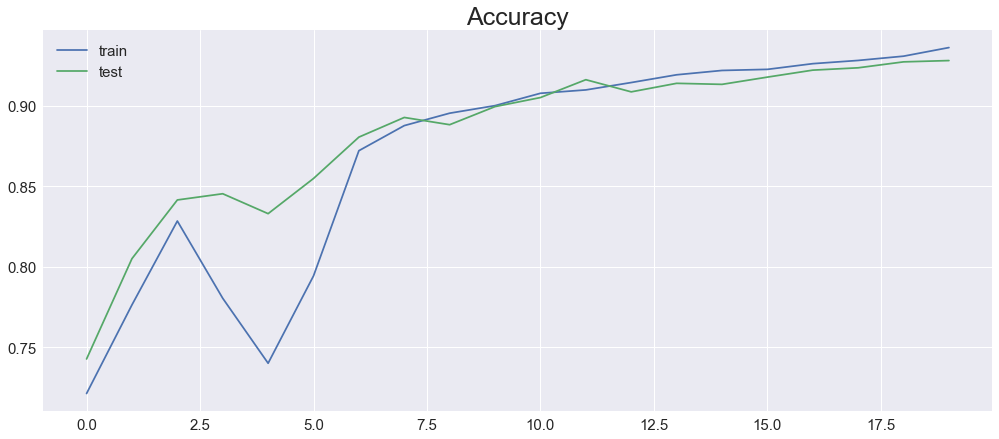

In [65]:
plt.figure(1, figsize=(17, 7))
plt.title('Accuracy', fontsize=25)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(prop={'size': 15})
plt.savefig('Accuracy Model 1.pdf')
plt.show();

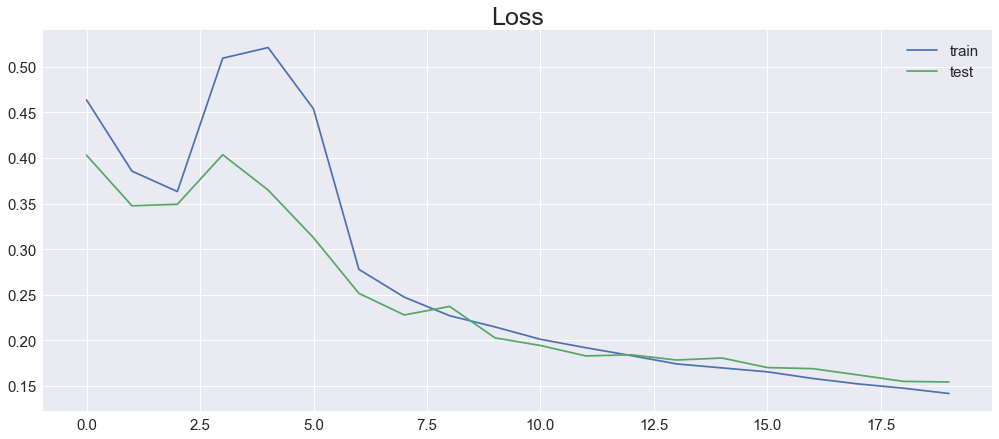

In [66]:
plt.figure(1, figsize=(17, 7))
plt.title('Loss', fontsize=25)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(prop={'size': 15})
plt.savefig('Loss Model 1.pdf')
plt.show()

###### Showing Some Examples

In [67]:
pred = model.predict(test_padded)

In [68]:
# 1 for Video Games, 0 for Musical Instruments

for i in range (train_size, train_size+10):
    print('Original Text:\n',reviews.text[i])
    print('Real Category:',test_labels[i])
    print('Predicted Category:', int(pred[i-train_size].round()))
    print('----------------------------------------')


Original Text:
 job works fine
Real Category: 0
Predicted Category: 0
----------------------------------------
Original Text:
 would say game sadly bit disappointing really one simple thing simply challenging logging around 20 hours game yet encounter 2 challenging fights battles encounter frequent rather annoying rarely lasting 5 seconds duration requiring two three hits per enemy rarely hit back ill add also encounter battles every 5 seconds dungeons world map characters frequently level almost every battle always end enough money purchase item find shops simply easy much fun wasnt game would quite good story decent voice acting done fairly well game offers enough interesting items upgrades keep things interesting simply easy easy enjoy
Real Category: 1
Predicted Category: 1
----------------------------------------
Original Text:
 great gift kids son loves playing wouldnt get anyone ubder 7 8 difficult play levels awesome game
Real Category: 1
Predicted Category: 1
------------------

# Product_Category Model 2

### TF-IDF Logistic Regression

In [69]:
train = ML.Text[:train_size]
train_labels = ML.product_category[:train_size]
test = ML.Text[train_size:]
test_labels = ML.product_category[train_size:]

In [70]:
def tfidf(data, ngrams=(1, 2)):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngrams)
    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer


train_tfidf, tfidf_vectorizer = tfidf(train)
test_tfidf = tfidf_vectorizer.transform(test)

In [71]:
model = LogisticRegression(class_weight="balanced")
model.fit(train_tfidf, train_labels)

LogisticRegression(class_weight='balanced')

In [72]:
y_pred = model.predict(test_tfidf)
f1score = f1_score(test_labels, y_pred)
accuracy = accuracy_score(test_labels, y_pred)

print(f"Model F1-Score: {f1score * 100} %")
print(f"Model Accuracy: {accuracy * 100} %")

Model F1-Score: 94.88462947137101 %
Model Accuracy: 93.26258240874739 %


ROC AUC (Training)=0.995
ROC AUC (Testing)=0.987


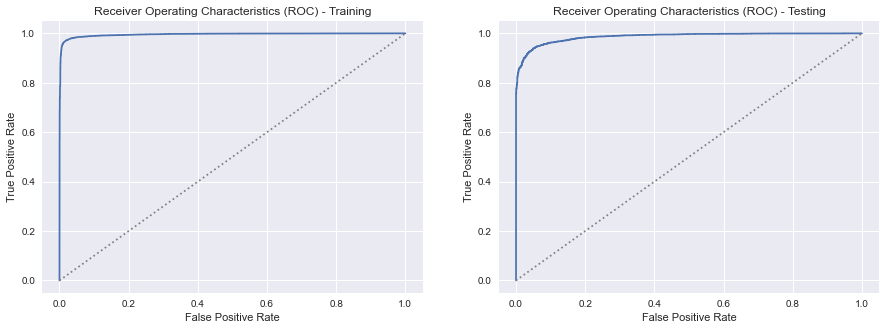

In [73]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def roc_classifier(grid, X_train, y_train, X_test, y_test):
    # predict probabilities
    lr_probs_train = grid.predict_proba(X_train)
    lr_probs_test = grid.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs_train = lr_probs_train[:, 1]
    lr_probs_test = lr_probs_test[:, 1]

    print('ROC AUC (Training)={:.3f}'.format(roc_auc_score(y_train, lr_probs_train)))
    print('ROC AUC (Testing)={:.3f}'.format(roc_auc_score(y_test, lr_probs_test)))

    # compute false positive and true positive rates
    lr_fpr_train, lr_tpr_train, _ = roc_curve(y_train, lr_probs_train)
    lr_fpr_test, lr_tpr_test, _ = roc_curve(y_test, lr_probs_test)

    # plot the roc curve for the training set
    _ = plt.figure(figsize=(15, 5))
    ax1 =plt.subplot(121)
    _ = ax1.plot(lr_fpr_train, lr_tpr_train, marker='x')
    _ = ax1.plot([0,1], [0, 1], 'gray', linestyle=':', marker='')
    _ = ax1.set_title('Receiver Operating Characteristics (ROC) - Training')
    _ = ax1.set_xlabel('False Positive Rate')
    _ = ax1.set_ylabel('True Positive Rate')

    # plot the roc curve for the testing set
    ax2 = plt.subplot(122)
    _ = ax2.plot(lr_fpr_test, lr_tpr_test, marker='x')
    _ = ax2.plot([0,1], [0, 1], 'gray', linestyle=':', marker='')
    _ = ax2.set_title('Receiver Operating Characteristics (ROC) - Testing')
    _ = ax2.set_xlabel('False Positive Rate')
    _ = ax2.set_ylabel('True Positive Rate')

    return (lr_probs_train, lr_fpr_train, lr_tpr_train, 
            lr_probs_test,  lr_fpr_test, lr_tpr_test)

lr_probs_train, lr_fpr_train, lr_tpr_train, lr_probs_test, lr_fpr_test, lr_tpr_test = roc_classifier(model, train_tfidf, train_labels, test_tfidf, test_labels)
plt.savefig('ROC PC.pdf')

###### Showing Some Examples

In [74]:
# 1 for Video Games, 0 for Musical Instruments

for i in range (train_size, train_size+10):
    print('Original Text:\n',reviews.text[i])
    print('Real Category:',test_labels[i])
    print('Predicted Category:', y_pred[i-train_size])
    print('----------------------------------------')

Original Text:
 job works fine
Real Category: 0
Predicted Category: 0
----------------------------------------
Original Text:
 would say game sadly bit disappointing really one simple thing simply challenging logging around 20 hours game yet encounter 2 challenging fights battles encounter frequent rather annoying rarely lasting 5 seconds duration requiring two three hits per enemy rarely hit back ill add also encounter battles every 5 seconds dungeons world map characters frequently level almost every battle always end enough money purchase item find shops simply easy much fun wasnt game would quite good story decent voice acting done fairly well game offers enough interesting items upgrades keep things interesting simply easy easy enjoy
Real Category: 1
Predicted Category: 1
----------------------------------------
Original Text:
 great gift kids son loves playing wouldnt get anyone ubder 7 8 difficult play levels awesome game
Real Category: 1
Predicted Category: 1
------------------

# Review_Score Model 1

### Multi-Class Logistic Regression

Evaluation Function

In [75]:
def evaluate_classifier(grid, X_train, y_train, X_test, y_test):
    # model evaluation for training set
    y_train_predict = grid.predict(X_train)
    print("Training SET")
    print("--------------------------------------")
    print('Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1 Score: {:.3f}'.format(accuracy_score(y_train, y_train_predict), 
                                                                                        precision_score(y_train, y_train_predict, average='weighted'), 
                                                                                        recall_score(y_train, y_train_predict, average='weighted'), 
                                                                                        f1_score(y_train, y_train_predict,average='weighted')))
    print("Confusion Matrix:\n {}".format(confusion_matrix(y_train, y_train_predict)))

    # model evaluation for testing set
    y_test_predict = grid.predict(X_test)

    print("\nTesting SET")
    print("--------------------------------------")
    print('Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1 Score: {:.3f}'.format(accuracy_score(y_test, y_test_predict), 
                                                                                        precision_score(y_test, y_test_predict, average='weighted'), 
                                                                                        recall_score(y_test, y_test_predict, average='weighted'), 
                                                                                        f1_score(y_test, y_test_predict, average='weighted')))
    print("Confusion Matrix:\n {}".format(confusion_matrix(y_test, y_test_predict)))
    return y_train_predict, y_test_predict

Splitting & Modelling

In [76]:
train_size = int(ML.shape[0] * 0.8)

train = ML.Text[:train_size]
train_labels = ML.Review_Score[:train_size]

test = ML.Text[train_size:]
test_labels = ML.Review_Score[train_size:]

In [77]:
train_tfidf, tfidf_vectorizer = tfidf(train)
test_tfidf = tfidf_vectorizer.transform(test)

In [78]:
model = LogisticRegression(class_weight="balanced", max_iter=1000)
model.fit(train_tfidf, train_labels)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [79]:
y_pred = model.predict(test_tfidf)
f1score = f1_score(test_labels, y_pred, average='weighted')
accuracy = accuracy_score(test_labels, y_pred)

print(f"Model F1-Score: {f1score * 100} %")
print(f"Model Accuracy: {accuracy * 100} %")

Model F1-Score: 64.83507430403547 %
Model Accuracy: 63.884868949991954 %


In [80]:
y_train_predict, y_test_predict = evaluate_classifier(model, train_tfidf, train_labels, test_tfidf, test_labels)

Training SET
--------------------------------------
Accuracy: 0.898, Precision: 0.909, Recall: 0.898, F1 Score: 0.900
Confusion Matrix:
 [[ 1435     2     0     3     5]
 [    1  1203     3     4     1]
 [   16     2  2412    13    32]
 [   49    18    66  4299   359]
 [  156    80   318  1397 13002]]

Testing SET
--------------------------------------
Accuracy: 0.639, Precision: 0.663, Recall: 0.639, F1 Score: 0.648
Confusion Matrix:
 [[ 225   44   32   21   36]
 [  77   77   70   33   33]
 [  38   56  239  163   89]
 [  27   48  144  609  400]
 [  78   41  148  668 2823]]


###### Showing Some Examples

In [81]:
for i in range (train_size, train_size+10):
    print('Original Text:\n',reviews.text[i])
    print('Real Score:',test_labels[i])
    print('Predicted Score:', y_pred[i-train_size])
    print('----------------------------------------')

Original Text:
 job works fine
Real Score: 5.0
Predicted Score: 3.0
----------------------------------------
Original Text:
 would say game sadly bit disappointing really one simple thing simply challenging logging around 20 hours game yet encounter 2 challenging fights battles encounter frequent rather annoying rarely lasting 5 seconds duration requiring two three hits per enemy rarely hit back ill add also encounter battles every 5 seconds dungeons world map characters frequently level almost every battle always end enough money purchase item find shops simply easy much fun wasnt game would quite good story decent voice acting done fairly well game offers enough interesting items upgrades keep things interesting simply easy easy enjoy
Real Score: 3.0
Predicted Score: 3.0
----------------------------------------
Original Text:
 great gift kids son loves playing wouldnt get anyone ubder 7 8 difficult play levels awesome game
Real Score: 5.0
Predicted Score: 5.0
------------------------

# Review_Score Model 2

### Multi-Class Bilinear Logistic Regression

In [82]:
train_size = int(ML.shape[0] * 0.8)

train = ML.Text[:train_size]
train_labels = ML.Review_Score[:train_size]

test = ML.Text[train_size:]
test_labels = ML.Review_Score[train_size:]

In [83]:
train_tfidf, tfidf_vectorizer = tfidf(train)
test_tfidf = tfidf_vectorizer.transform(test)

In [84]:
model = LogisticRegression(class_weight="balanced", solver='liblinear', penalty='l2')
model.fit(train_tfidf, train_labels)

LogisticRegression(class_weight='balanced', solver='liblinear')

In [85]:
y_pred = model.predict(test_tfidf)
f1score = f1_score(test_labels, y_pred, average='weighted')
accuracy = accuracy_score(test_labels, y_pred)

print(f"Model F1-Score: {f1score * 100} %")
print(f"Model Accuracy: {accuracy * 100} %")

Model F1-Score: 66.12257308017611 %
Model Accuracy: 67.8726483357453 %


In [86]:
y_train_predict, y_test_predict = evaluate_classifier(model, train_tfidf, train_labels, test_tfidf, test_labels)

Training SET
--------------------------------------
Accuracy: 0.895, Precision: 0.894, Recall: 0.895, F1 Score: 0.892
Confusion Matrix:
 [[ 1424     4     1     4    12]
 [    9  1178     6     8    11]
 [   30     3  2199    30   213]
 [   44    12    60  3239  1436]
 [   68    27   128   498 14232]]

Testing SET
--------------------------------------
Accuracy: 0.679, Precision: 0.652, Recall: 0.679, F1 Score: 0.661
Confusion Matrix:
 [[ 204   38   27   13   76]
 [  68   61   65   30   66]
 [  30   41  205  134  175]
 [  18   26   96  457  631]
 [  40   14   80  330 3294]]


###### Showing Some Examples

In [87]:
for i in range (train_size, train_size+10):
    print('Original Text:\n',reviews.text[i])
    print('Real Score:',test_labels[i])
    print('Predicted Score:', y_pred[i-train_size])
    print('----------------------------------------')

Original Text:
 job works fine
Real Score: 5.0
Predicted Score: 3.0
----------------------------------------
Original Text:
 would say game sadly bit disappointing really one simple thing simply challenging logging around 20 hours game yet encounter 2 challenging fights battles encounter frequent rather annoying rarely lasting 5 seconds duration requiring two three hits per enemy rarely hit back ill add also encounter battles every 5 seconds dungeons world map characters frequently level almost every battle always end enough money purchase item find shops simply easy much fun wasnt game would quite good story decent voice acting done fairly well game offers enough interesting items upgrades keep things interesting simply easy easy enjoy
Real Score: 3.0
Predicted Score: 3.0
----------------------------------------
Original Text:
 great gift kids son loves playing wouldnt get anyone ubder 7 8 difficult play levels awesome game
Real Score: 5.0
Predicted Score: 5.0
------------------------